In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import logging
import math
import os
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

df= pd.read_csv(os.path.join('/Users/kim-woo-won/Documents/SK하이닉스 13~23.csv'), encoding='utf8')
df.describe()

2023-06-20 15:11:27.844868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,Open,Higt,Low,Close,Volume,RSI,RSISignal,CCI,CCISignal,UpDI,...,Close5ma,Close10ma,Close20ma,Close60ma,INDNB,INSNB,FNB,Call,EX,SSR
count,2566.000000,2566.000000,2566.000000,2566.000000,2.566000e+03,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,...,2566.000000,2566.000000,2566.000000,2566.000000,2.566000e+03,2.566000e+03,2.566000e+03,2566.000000,2566.000000,2566.000000
mean,68822.798129,69714.127046,67836.730320,68737.996882,3.723025e+06,0.519573,0.519210,8.346485,8.160978,24.632529,...,100.121871,100.275908,100.566668,101.683562,-3.927260e+04,-4.770122e+04,7.086816e+04,1.633597,1151.659158,4.558009
std,30681.834072,31095.626517,30178.490951,30629.049394,1.960378e+06,0.159519,0.131400,107.891457,77.176467,10.247633,...,2.336750,3.458962,4.975842,8.721343,9.203666e+05,5.702654e+05,8.078597e+05,0.760747,76.541358,4.379647
min,23850.000000,24200.000000,23600.000000,23700.000000,8.425620e+05,0.066300,0.137700,-276.060000,-158.160000,1.430000,...,89.470000,83.890000,77.860000,72.630000,-4.928607e+06,-9.953327e+06,-8.331951e+06,0.000000,1008.500000,0.000000
25%,41000.000000,41350.000000,40350.000000,40900.000000,2.442582e+06,0.405450,0.425975,-76.547500,-59.485000,17.350000,...,98.610000,98.042500,97.297500,95.250000,-4.456775e+05,-2.817880e+05,-2.763015e+05,1.230000,1104.625000,1.400000
50%,71800.000000,73000.000000,70800.000000,71750.000000,3.258910e+06,0.515400,0.513750,13.300000,10.525000,23.590000,...,100.080000,100.230000,100.415000,101.410000,-2.561400e+04,-3.520400e+04,6.506750e+04,1.490000,1134.400000,3.445000
75%,87900.000000,89000.000000,86500.000000,87875.000000,4.465971e+06,0.634575,0.614100,90.610000,75.535000,30.812500,...,101.650000,102.467500,103.880000,107.635000,3.670838e+05,2.102022e+05,3.976848e+05,2.217500,1187.500000,6.445000
max,149000.000000,150500.000000,142500.000000,148500.000000,2.101944e+07,0.972600,0.902800,361.630000,168.680000,68.210000,...,112.250000,113.030000,118.840000,135.500000,7.821111e+06,3.168361e+06,1.065220e+07,3.770000,1439.900000,59.530000


In [2]:
price_indicator = df.loc[:,'Open':'Close'].values[1:].astype(float) # 가격 관련 지표 / Price Indicator
volume_indicator = df.loc[:,'Volume':'Volume'].values[1:].astype(float) # 거래량 관련 지표 / Volume Indicator
etc_indicator = df.loc[:,'RSI':'WilliamsR'].values[1:].astype(float) # 추세 또는 거래량 활용 지표 / Trend and Volume Indicator

scaler = MinMaxScaler(feature_range=(0, 1)) # 0~1 값으로 스케일링
scaler_etc = MinMaxScaler(feature_range=(-1, 1)) # -1~1 값으로 스케일링

scaled_price_indicator = scaler.fit_transform(price_indicator) # 가격 관련 지표에 스케일링
scaled_volume_indicator = scaler.fit_transform(volume_indicator) # 거래량 관련 지표에 스케일링
scaled_etc_indicator = scaler_etc.fit_transform(etc_indicator) # 추세 또는 거래량 활용 지표에 스케일링

In [3]:
# 데이터셋 생성하기 / Creating Dataset
seq_length = 11

# 행은 그대로 두고 열을 우측에 붙여 합친다 / leave the row, and attach columns to right
x = np.concatenate((scaled_price_indicator, scaled_volume_indicator, scaled_etc_indicator), axis=1) # axis=1
y = x[:, [3]] # 타켓은 주식 종가이다 / target is 'Close' price

dataX = []  # 입력으로 사용될 Sequence Data / Input - Sequence Data
dataY = []  # 출력(타겟)으로 사용 / Output(target)
for i in range(0, int(len(y) - seq_length)):
    _x = x[i : i + seq_length]
    _y = y[i + seq_length] # 다음 나타날 주가(정답) / after 5 days later (in _x), 'Close' price is the correct answer.
    dataX.append(_x) # dataX 리스트에 추가 / add to dataX's list
    dataY.append(_y) # dataY 리스트에 추가 / add to dataY's list

In [4]:
# 학습용/테스트용 데이터 생성
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size

# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])


In [5]:
print("="*50)
print(_x.shape)
print(_y.shape)
print(testY.shape)
print(trainY.shape)

print("="*50)

(11, 15)
(1,)
(767, 1)
(1787, 1)


In [182]:
input_shape = (seq_length, trainX.shape[2])

model = Sequential()
model.add(LSTM(64, input_shape=input_shape, return_sequences=True))  # Increased number of neurons
model.add(Dropout(0.015))  # Reduced dropout rate
model.add(LSTM(64))  # Increased number of neurons
model.add(Dropout(0.015))  # Reduced dropout rate
model.add(Dense(1))
model.add(Activation('softsign')) #linear / softsign
print(input_shape)


(11, 15)


In [183]:
adam = optimizers.Adam(learning_rate=0.005)
model.compile(loss='mean_squared_error', optimizer=adam)
model.summary()

model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


# 모델 학습
history = model.fit(trainX, trainY, epochs=10, batch_size=64, 
                    verbose=1, validation_data=(testX, testY))

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 11, 64)            20480     
                                                                 
 dropout_68 (Dropout)        (None, 11, 64)            0         
                                                                 
 lstm_69 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_69 (Dropout)        (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 1)                 65        
                                                                 
 activation_34 (Activation)  (None, 1)                 0         
                                                                 
Total params: 53,569
Trainable params: 53,569
Non-tra

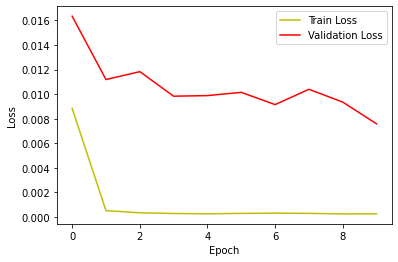

In [184]:
# 학습 과정 살펴보기
plt.plot(history.history['loss'],'y', label='Train Loss')
plt.plot(history.history['val_loss'],'r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [171]:
# print(hist.history['val_loss'])

24/24 [==============================] - 1s 5ms/step


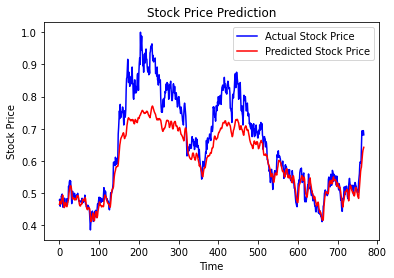

In [10]:
# 예측 수행
y_pred = model.predict(testX)

# 결과 그래프
plt.plot(testY, color='blue', label='Actual Stock Price')
plt.plot(y_pred, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.show()